In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import hmp
from mne.io import read_info
import pandas as pd
from scipy.stats import linregress, ttest_1samp


eeg_data_path = os.path.join('data','preprocessed/')#Declaring path where the eeg data is
subj_names = [x.split('.')[0] for x in os.listdir(eeg_data_path) if '.fif' in x]#Extracting subject name based on the file name
subj_files = [eeg_data_path+x+'.fif' for x in subj_names]#Create a list of files that can be read from the folder

# Load sensor position for an example participants (assumes all have the same channel position)
info = read_info(subj_files[0], verbose=True)

sfreq = info['sfreq'] #at what sampling rate we want the data, replace with 100Hz for speed/RAM
tstep = (1000/sfreq) #Time step for plotting

epoch_data = hmp.io.read_mne_data(subj_files, epoched=True, sfreq=sfreq, 
                                     lower_limit_rt=.1,
                                     offset_after_resp=.01,#add 10ms, avoid edge effects
                                     reject_threshold=1e-4,
                                     verbose=True,
                                     subj_idx=subj_names)
# REcover estiation
model = hmp.io.load_model('estimation_files/model.pkl')
estimates = hmp.io.load_model('estimation_files/estimates.pkl')

Processing participant data/preprocessed/6_epo.fif's epoched eeg
Reading /home/gabriel/ownCloud/projects/RUGUU/decision_times/data/preprocessed/6_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    3000.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
1116 matching events found
No baseline correction applied
0 projection items activated
Applying reaction time trim to keep RTs between 0.1 and 2.991953125 seconds
1093 RTs kept of 1116 clean epochs
0 trials rejected based on threshold of 0.0001
1093 trials were retained for participant data/preprocessed/6_epo.fif
End sampling frequency is 512.0 Hz
Processing participant data/preprocessed/19_epo.fif's epoched eeg
Reading /home/gabriel/ownCloud/projects/RUGUU/decision_times/data/preprocessed/19_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    3000.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
1116 matching events found
No ba

In [2]:
colors_cond = colors = {'accuracy':'royalblue', 'speed':'indianred'}
color_model = {'linear':'k','fechner_linear':'goldenrod'}
sat_ax = {'speed':1, 'accuracy':0}
nice_names = {'fechner_linear':r'$Fechner$', 'linear':r'$Linear$'}

In [3]:
times_sp = hmp.utils.event_times(estimates, mean=False, add_rt=True, add_stim=True)

tstep = 1000/sfreq 

data = epoch_data.stack({'trial':['participant','epoch']}).data.dropna('trial', how="all")
data['stimulus'] = data.stimulus.astype(int)
weights =  hmp.utils.event_channels(epoch_data, estimates, mean=True)

name_sat = {'speed':'Speed','accuracy':'Accuracy'}
ax_sat = {"speed":0, "accuracy":1}
channels = info['ch_names'][:32]
decision_event = 2

In [4]:
def compute_regression(samples, data):
    slope, intercept, _, _, _ = linregress(samples, data)
    return slope, intercept
    

baseline = int(np.rint(-.25*sfreq))
n_samples = 0
event = 2
contrasts = np.sort(np.unique(data.stimulus.values))
slopes = np.zeros((2, len(np.unique(data.participant)), len(contrasts)))*np.nan
intercepts = np.zeros((2, len(np.unique(data.participant)), len(contrasts)))*np.nan
prop_corr = np.zeros((2, len(np.unique(data.participant)), len(contrasts)))*np.nan

for c, SAT in enumerate(["speed","accuracy"]):
    for j, cont in enumerate(contrasts):
        data_left_sp = data.where((data.stimulus == cont) & (data.condition == SAT), drop=True)

        centered = hmp.utils.centered_activity(data_left_sp, times_sp, channels,
            event=event+1, n_samples=n_samples, 
            baseline=baseline).unstack().data*1e10
        
        by_trial_timecourse = xr.apply_ufunc(
            np.matmul,
            centered.mean('epoch'),
            weights.sel(event=event)[:, 0],
            input_core_dims=[["channel"], ["channel"]],
            vectorize=True
        ).T

        tofit = by_trial_timecourse.sel(sample=slice(baseline, n_samples))
        
        c_slopes, c_intercepts = xr.apply_ufunc(
            compute_regression,
            tofit.sample,
            tofit, 
            input_core_dims=[["sample"], ["sample"]],
            output_core_dims=[[], []],
            vectorize=True
        )
        # Some participants might not have a given contrast value, e.g. rejected trials based on threshold or too fast RT
        slopes[c, :len(c_slopes), j] = c_slopes
        intercepts[c, :len(c_slopes), j] = c_intercepts

        resp = data_left_sp['response'].dropna('trial').unstack()
        side = data_left_sp['side'].dropna('trial').unstack()
        for i, participant in enumerate(resp.participant):
            prop_corr[c, i, j] = (resp.sel(participant = participant).dropna('epoch') == side.sel(participant = participant).dropna('epoch')).mean(dim="epoch").values



In [5]:
for c, SAT in enumerate(["speed","accuracy"]):
    print(ttest_1samp(np.nanmean(slopes[c],axis=0), 0, alternative='greater'))

TtestResult(statistic=np.float64(31.949087360925486), pvalue=np.float64(6.858269434883165e-52), df=np.int64(92))
TtestResult(statistic=np.float64(21.107022478706053), pvalue=np.float64(2.4788174682861958e-37), df=np.int64(92))


In [6]:
color_cont_spd = {x: plt.cm.Reds(x/100) for x in contrasts}
color_cont_acc = {x: plt.cm.Blues(x/100) for x in contrasts}
color_sat = {'speed':color_cont_spd,'accuracy':color_cont_acc}


R = 0.41, p = 0.000
R = 0.68, p = 0.000
R = 0.57, p = 0.000
R = 0.66, p = 0.000


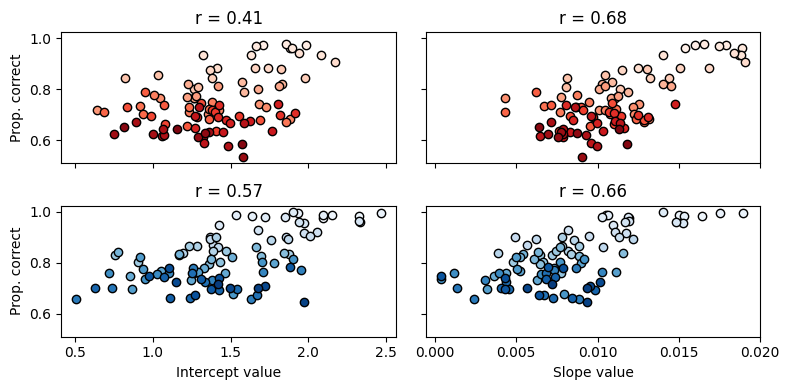

In [7]:
from scipy.stats import pearsonr
fig, axes = plt.subplots(2,2, sharey=True, sharex='col', figsize=(8, 4))
for c, SAT in enumerate(["speed","accuracy"]):
    avg_prop_corr = np.nanmean(prop_corr[c], axis=0)
    for p, parameter in enumerate([intercepts, slopes]):
        avg_par_value = np.nanmean(parameter[c,:,:],axis=0)
        for i, contrast in enumerate(contrasts):
            axes[c, p].plot(avg_par_value[i], avg_prop_corr[i], 'o', 
                            color=color_sat[SAT][contrast],
                            markeredgecolor='black',markeredgewidth=1)
        r, pval = pearsonr(avg_par_value, avg_prop_corr)
        axes[c, p].set_title(f'r = {r:.2f}')
        print(f'R = {r:.2f}, p = {pval:.3f}')
    axes[0,0].set(ylabel='Prop. correct')
    axes[1,0].set(ylabel='Prop. correct', xlabel='Intercept value')
    axes[1,1].set( xlabel='Slope value') 

plt.tight_layout()
plt.savefig('plots/ramp_behavior.png',dpi=300,transparent=True,bbox_inches='tight')